In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit,col,sum
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
from mlflow.tracking import MlflowClient
import mlflow
import sklearn
import mlflow.pyfunc
import mlflow.sklearn
import cloudpickle
import os
import time

In [2]:
spark = SparkSession.builder.master("local[1]").appName("SparkExample").getOrCreate()

22/02/26 22:11:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
os.environ["AWS_ACCESS_KEY_ID"] = "minioadmin"
os.environ["AWS_SECRET_ACCESS_KEY"] = "minioadmin"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://10.104.10.14:9000/"

In [4]:
mlflow.set_tracking_uri('http://10.101.139.34:5000')

In [5]:
red_wine_df = spark.read.options(header=True,inferSchema=True,sep=';').csv('./winequality-red.csv')
white_wine_df = spark.read.options(header=True,inferSchema=True,sep=';').csv('./winequality-white.csv')

In [6]:
white_wine_df.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [7]:
red_wine_df = red_wine_df.withColumn('is_red',lit(1))
white_wine_df = white_wine_df.withColumn('is_red',lit(0))

In [8]:
wine_df = red_wine_df.union(white_wine_df)

In [9]:
wine_df.describe()

DataFrame[summary: string, fixed acidity: string, volatile acidity: string, citric acid: string, residual sugar: string, chlorides: string, free sulfur dioxide: string, total sulfur dioxide: string, density: string, pH: string, sulphates: string, alcohol: string, quality: string, is_red: string]

Check nulls

In [10]:
wine_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in wine_df.columns)).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
wine_df.createOrReplaceTempView("data")

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

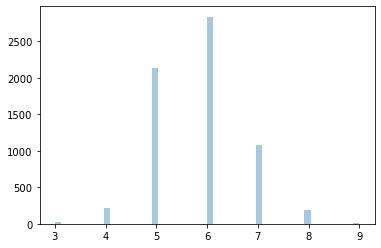

In [12]:
sns.distplot(spark.sql("select quality from data").toPandas(),kde=False)

In [13]:
wine_df = wine_df.withColumn("high_quality",(col("quality") >= 7).cast("int") )

In [14]:
wine_pandas = wine_df.toPandas()
wine_pandas = wine_pandas.drop("quality",axis=1)
X = wine_pandas.drop("high_quality",axis=1)
y = wine_pandas['high_quality']

X_train,X_test,y_train,y_test = train_test_split(X,y)

In [15]:
class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model

    def predict(self, context, model_input):
        return self.model.predict_proba(model_input)[:,1]

In [16]:
with mlflow.start_run(run_name='untuned_random_forest'):
    n_estimators = 10
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
    model.fit(X_train, y_train)
    predictions_test = model.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, predictions_test)
    
    mlflow.log_param('n_estimators', n_estimators)
    mlflow.log_metric('auc', auc_score)
    wrappedModel = SklearnModelWrapper(model)
    # Log the model with a signature that defines the schema of the model's inputs and outputs. 
    # When the model is deployed, this signature will be used to validate inputs.
    signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
    
    conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
    mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)

/opt/conda/lib/python3.9/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


In [17]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

,importance
alcohol,0.146694
density,0.124218
residual sugar,0.088412
total sulfur dioxide,0.084885
volatile acidity,0.084418
pH,0.082990
sulphates,0.081775
chlorides,0.079623
free sulfur dioxide,0.076907
citric acid,0.075586


Register in MLFlow

In [18]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "untuned_random_forest"').iloc[0].run_id
model_name = "wine_quality"

model_version = mlflow.register_model(f"runs:/{run_id}/random_forest_model", model_name)
# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Successfully registered model 'wine_quality'.
2022/02/26 22:12:10 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: wine_quality, version 1
Created version '1' of model 'wine_quality'.


Move to production

In [19]:
client = MlflowClient()

client.transition_model_version_stage(
    name=model_name,
    version=model_version.version,
    stage="Production",

)

<ModelVersion: creation_timestamp=1645913530323, current_stage='Production', description='', last_updated_timestamp=1645913545426, name='wine_quality', run_id='369aa4d2cd1c43899ef2209d5635f042', run_link='', source='s3://mlflow/0/369aa4d2cd1c43899ef2209d5635f042/artifacts/random_forest_model', status='READY', status_message='', tags={}, user_id='', version='1'>

Download model

In [20]:
model = mlflow.pyfunc.load_model(
    model_uri=f"models:/{model_name}/Production"
)

print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

AUC: 0.8895300180592873
